<a href="https://colab.research.google.com/github/prity2803/melanoma-detecion-using-NN/blob/main/CNNassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2254
118


In [5]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 2254 files belonging to 9 classes.
Using 1804 files for training.


In [6]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2254 files belonging to 9 classes.
Using 450 files for validation.


Found 2254 files belonging to 9 classes.


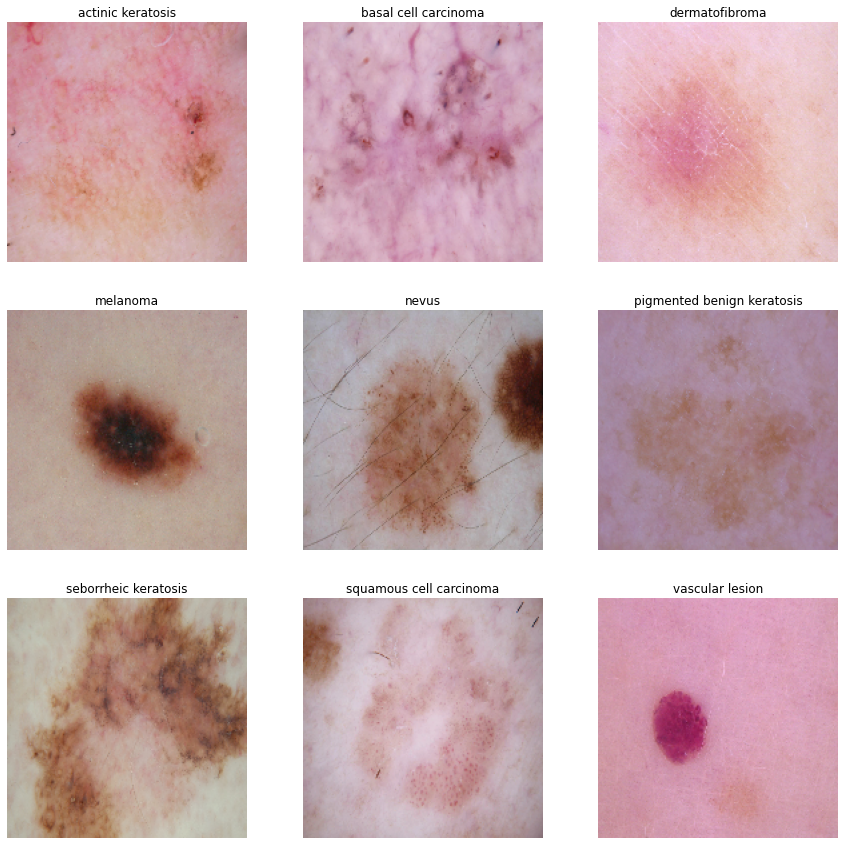

In [7]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [8]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(16,3, padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#Second Convulation Layer
model.add(layers.Conv2D(16,3, padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#Third Convulation Layer
model.add(layers.Conv2D(64,3, padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#fourth Convulation Layer
model.add(layers.Conv2D(32,3,padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#fifth Convulation Layer 
model.add(layers.Conv2D(64,3,padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#Dropout layer with 20% Fraction of the input units to drop.
#model.add(layers.Dropout(0.20))

#sixth Convulation Layer 
#model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(9,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        9

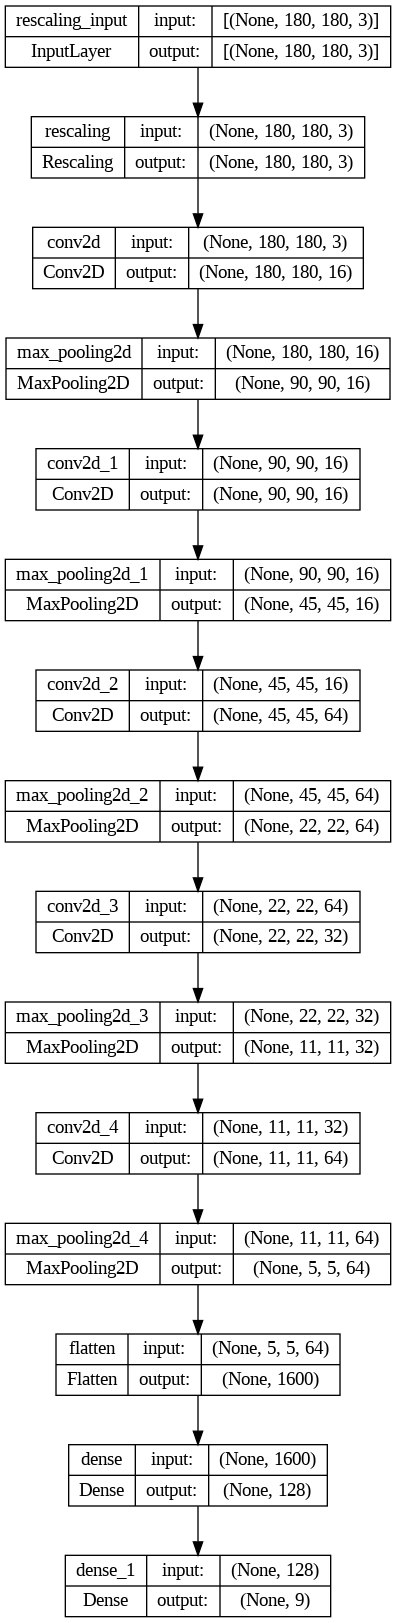

In [10]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [12]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
57/57 [==============================] - 193s 645ms/step - loss: 2.0409 - accuracy: 0.2045 - val_loss: 2.0084 - val_accuracy: 0.2022
Epoch 2/20
57/57 [==============================] - 1s 19ms/step - loss: 1.9239 - accuracy: 0.2788 - val_loss: 1.8028 - val_accuracy: 0.3267
Epoch 3/20
57/57 [==============================] - 1s 19ms/step - loss: 1.6527 - accuracy: 0.3902 - val_loss: 1.5724 - val_accuracy: 0.4022
Epoch 4/20
57/57 [==============================] - 1s 20ms/step - loss: 1.5057 - accuracy: 0.4562 - val_loss: 1.5437 - val_accuracy: 0.4489
Epoch 5/20
57/57 [==============================] - 1s 20ms/step - loss: 1.4065 - accuracy: 0.5161 - val_loss: 1.6018 - val_accuracy: 0.4378
Epoch 6/20
57/57 [==============================] - 1s 19ms/step - loss: 1.3911 - accuracy: 0.5044 - val_loss: 1.5225 - val_accuracy: 0.4889
Epoch 7/20
57/57 [==============================] - 1s 18ms/step - loss: 1.3551 - accuracy: 0.5061 - val_loss: 1.4249 - val_accuracy: 0.5089
Epoch 8/20

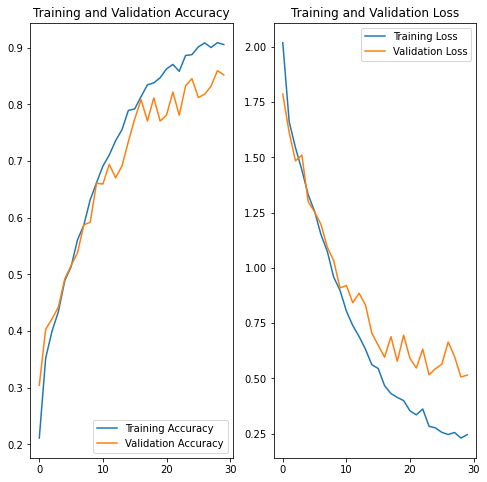

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

### Training accuracy is increasing whereas validation accuracy is constant at a particular range and same goes with validation loss and training loss, training loss is constantly decresing whereas validation loss is increasing after a particular point, could be the case of overfitting so let's introduce some dropiut layers and earlystop in the neural nw

In [14]:
#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(16,3, padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#Second Convulation Layer
model.add(layers.Conv2D(16,3, padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#Third Convulation Layer
model.add(layers.Conv2D(64,3, padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#fourth Convulation Layer
model.add(layers.Conv2D(32,3,padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#fifth Convulation Layer 
model.add(layers.Conv2D(64,3,padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#Dropout layer with 20% Fraction of the input units to drop.
model.add(layers.Dropout(0.20))

#sixth Convulation Layer 
#model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(9,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 64)       

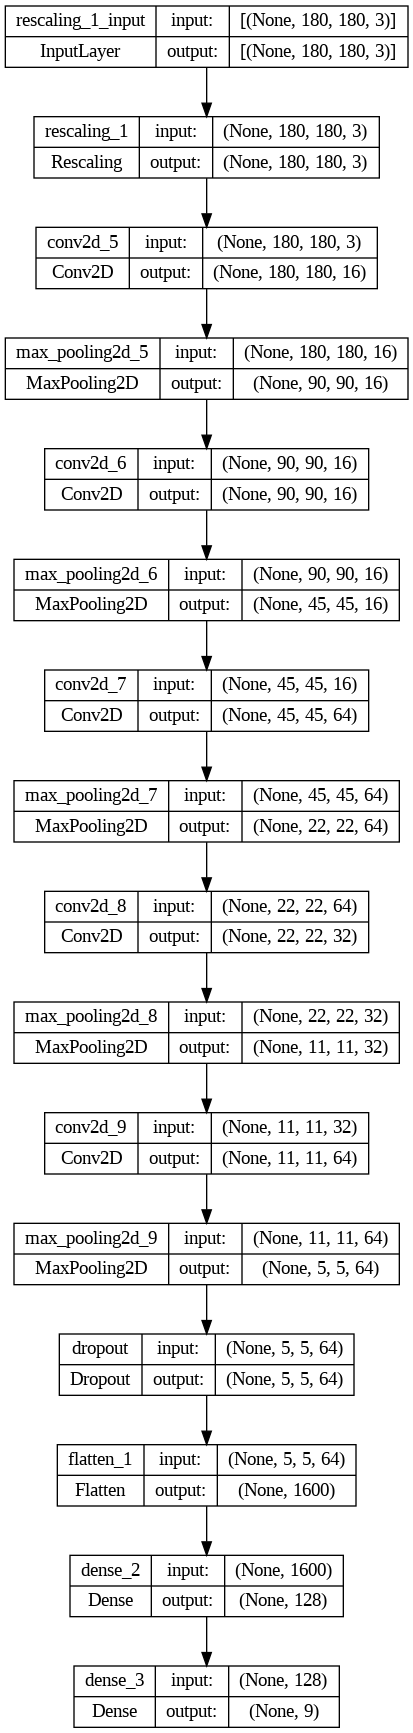

In [15]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [17]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint])

Epoch 1/20
55/57 [===========================>..] - ETA: 0s - loss: 2.0516 - accuracy: 0.1937
Epoch 1: val_accuracy improved from -inf to 0.16444, saving model to model.h5
57/57 [==============================] - 4s 30ms/step - loss: 2.0508 - accuracy: 0.1924 - val_loss: 2.0502 - val_accuracy: 0.1644
Epoch 2/20
56/57 [============================>.] - ETA: 0s - loss: 1.9562 - accuracy: 0.2466
Epoch 2: val_accuracy improved from 0.16444 to 0.29333, saving model to model.h5
57/57 [==============================] - 1s 26ms/step - loss: 1.9540 - accuracy: 0.2467 - val_loss: 1.8334 - val_accuracy: 0.2933
Epoch 3/20
55/57 [===========================>..] - ETA: 0s - loss: 1.8340 - accuracy: 0.3109
Epoch 3: val_accuracy improved from 0.29333 to 0.40667, saving model to model.h5
57/57 [==============================] - 2s 27ms/step - loss: 1.8342 - accuracy: 0.3082 - val_loss: 1.7436 - val_accuracy: 0.4067
Epoch 4/20
55/57 [===========================>..] - ETA: 0s - loss: 1.6988 - accuracy: 0

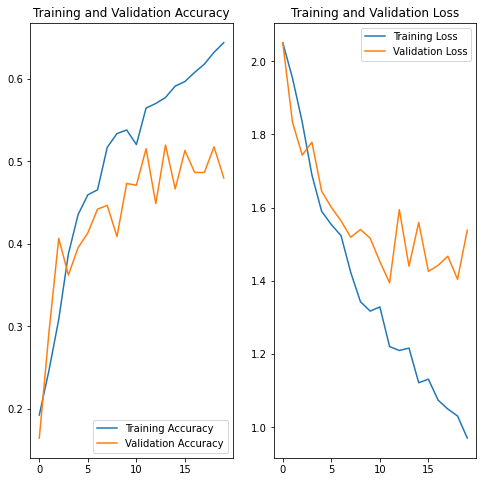

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

### Using dropout with checkpoints has worsened the results so let's check for class imbalance and see how training data is scattered along the classes

In [19]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,squamous cell carcinoma,181
2,pigmented benign keratosis,462
3,actinic keratosis,114
4,melanoma,438
5,seborrheic keratosis,77
6,dermatofibroma,95
7,nevus,365
8,basal cell carcinoma,383


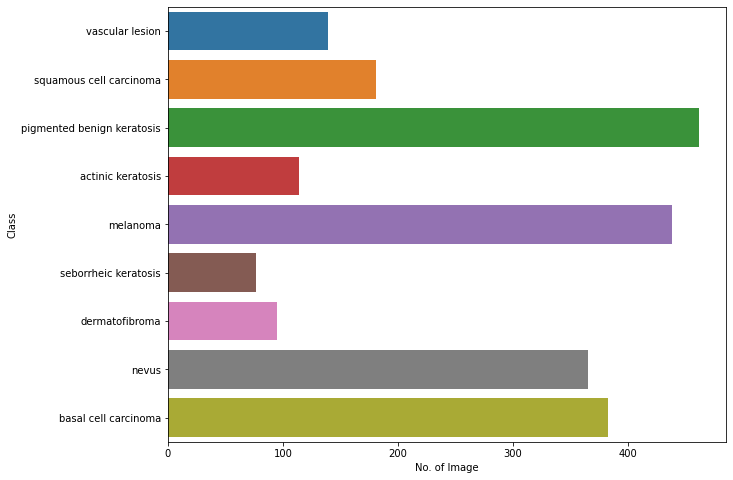

In [20]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [21]:
#install Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### It is clearly visible that some classes have more training data compared to other class so let's add some more training data using augementor

In [22]:
path_to_training_dataset="/content/gdrive/MyDrive/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F49C062FC10>: 100%|██████████| 500/500 [00:26<00:00, 19.22 Samples/s]


Initialised with 383 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F49C07B05B0>: 100%|██████████| 500/500 [00:33<00:00, 15.01 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F49C0745310>: 100%|██████████| 500/500 [00:21<00:00, 23.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F49C04206D0>: 100%|██████████| 500/500 [01:42<00:00,  4.86 Samples/s]


Initialised with 365 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F49C062F340>: 100%|██████████| 500/500 [01:50<00:00,  4.52 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F49C0573250>: 100%|██████████| 500/500 [00:21<00:00, 22.98 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F49C05F9070>: 100%|██████████| 500/500 [00:46<00:00, 10.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F494C47DA60>: 100%|██████████| 500/500 [00:19<00:00, 25.59 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F49C05A2A30>: 100%|██████████| 500/500 [00:21<00:00, 23.07 Samples/s]


In [23]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [24]:
from glob import *
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_cc2e2e80-241f-4382-ad01-a7ea8f8f2227.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0029099.jpg_3f2c9eee-c0fe-4de2-93f3-293e04c9dc74.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0029889.jpg_2f13589f-725f-4677-9770-9865789eeb4b.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0031197.jpg_90e6e067-c78e-40bb-99b8-a04cdf737820.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0025680.jpg_ea059780-de0f-4764-b7dc-4dd66357f516.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0033591.jpg_808aaa25-3475-456e-8d8d-2f39b3ab9e65.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0031093.jpg_05ad90d8-8783-4b42-9c15-c78eeed58d08.jpg',
 '/content/gdrive/My

In [25]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new
     

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [26]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [27]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [28]:
new_df['Label'].value_counts()

vascular lesion               500
squamous cell carcinoma       500
pigmented benign keratosis    500
actinic keratosis             500
melanoma                      500
seborrheic keratosis          500
dermatofibroma                500
nevus                         500
basal cell carcinoma          500
Name: Label, dtype: int64

In [29]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)


Found 6754 files belonging to 9 classes.
Using 5404 files for training.


In [30]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6754 files belonging to 9 classes.
Using 1350 files for validation.


In [31]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(16,3, padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#Second Convulation Layer
model.add(layers.Conv2D(16,3, padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#Third Convulation Layer
model.add(layers.Conv2D(64,3, padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#fourth Convulation Layer
model.add(layers.Conv2D(32,3,padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#fifth Convulation Layer 
model.add(layers.Conv2D(64,3,padding='same',activation='relu'))
model.add(layers.MaxPool2D())

#Dropout layer with 20% Fraction of the input units to drop.
model.add(layers.Dropout(0.20))

#sixth Convulation Layer 
#model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(9,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 64)       

In [33]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [34]:
# Train the model
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 51s 70ms/step - loss: 2.0183 - accuracy: 0.2113 - val_loss: 1.7858 - val_accuracy: 0.3044
Epoch 2/30
169/169 [==============================] - 4s 24ms/step - loss: 1.6614 - accuracy: 0.3523 - val_loss: 1.6128 - val_accuracy: 0.4030
Epoch 3/30
169/169 [==============================] - 4s 24ms/step - loss: 1.5429 - accuracy: 0.3997 - val_loss: 1.4839 - val_accuracy: 0.4215
Epoch 4/30
169/169 [==============================] - 4s 25ms/step - loss: 1.4425 - accuracy: 0.4343 - val_loss: 1.5099 - val_accuracy: 0.4422
Epoch 5/30
169/169 [==============================] - 4s 24ms/step - loss: 1.3303 - accuracy: 0.4887 - val_loss: 1.2987 - val_accuracy: 0.4919
Epoch 6/30
169/169 [==============================] - 4s 24ms/step - loss: 1.2558 - accuracy: 0.5135 - val_loss: 1.2534 - val_accuracy: 0.5156
Epoch 7/30
169/169 [==============================] - 4s 26ms/step - loss: 1.1506 - accuracy: 0.5607 - val_loss: 1.1969 - val_accuracy: 0.537

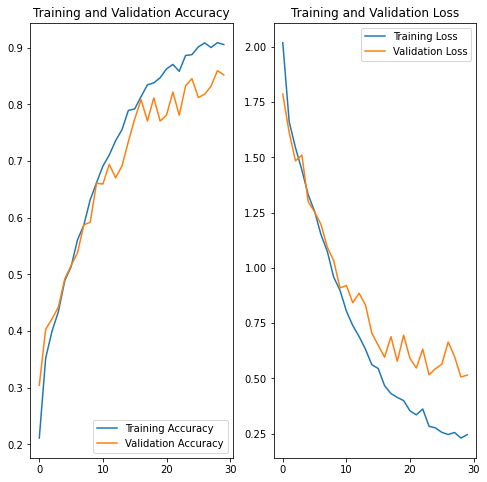

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model Prediction

In [36]:
df2 = class_distribution_count(data_dir_test)
df2

,Class,No. of Image
0,melanoma,16
1,seborrheic keratosis,3
2,nevus,16
3,dermatofibroma,16
4,basal cell carcinoma,16
5,squamous cell carcinoma,16
6,actinic keratosis,16
7,vascular lesion,3
8,pigmented benign keratosis,16


1/1 [==============================] - 0s 38ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


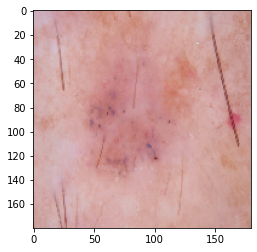

In [40]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[2],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

1/1 [==============================] - 0s 28ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


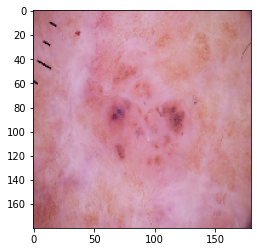

In [38]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[9],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )